In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [3]:
# Hyper Parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [4]:
# MNIST Dataset
train_dataset = dsets.MNIST(root='./data/',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./data/',
                           train=False,
                           transform=transforms.ToTensor())

Processing...
Done!


In [5]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

images.size(): torch.Size([100, 1, 28, 28])
labels.size(): torch.Size([100])

npimages_t.shape: (100, 28, 28, 1)


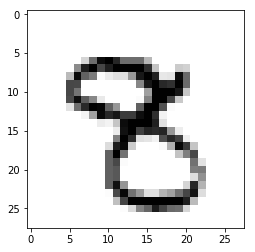


npgrids.shape  : (3, 392, 242)
npgrids_t.shape: (392, 242, 3)


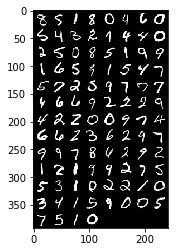

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Print MNIST Dataset w/ Data Loader

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('images.size():', images.size())
print('labels.size():', labels.size())

npimages = images.numpy()
npimages_t = np.transpose(npimages, (0, 2, 3, 1))
print()
print('npimages_t.shape:', npimages_t.shape)
plt.imshow(npimages_t[0].reshape((28,28)), cmap=plt.cm.binary)
plt.show()

grids = torchvision.utils.make_grid(images)
npgrids = grids.numpy()
npgrids_t = np.transpose(npgrids, (1, 2, 0))
print()
print('npgrids.shape  :', npgrids.shape)
print('npgrids_t.shape:', npgrids_t.shape)

plt.imshow(npgrids_t)
plt.show()

In [36]:
# RNN Model (Many-to-One)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, 
                 num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial states
        h0 = Variable(torch.zeros(self.num_layers, 
                                  x.size(0), 
                                  self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, 
                                  x.size(0), 
                                  self.hidden_size))
        
        # Forward propagate RNN
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

In [37]:
rnn = RNN(input_size, hidden_size, num_layers, num_classes)

In [38]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [39]:
# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size))
        labels = Variable(labels)
        
        # Forward + Backward + Optimizer
        optimizer.zero_grad()
        outputs = rnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, 
                   i+1, len(train_dataset)//batch_size, 
                   loss.data[0]))

Epoch [1/2], Step [100/600], Loss: 0.6318
Epoch [1/2], Step [200/600], Loss: 0.2056
Epoch [1/2], Step [300/600], Loss: 0.2647
Epoch [1/2], Step [400/600], Loss: 0.1465
Epoch [1/2], Step [500/600], Loss: 0.1079
Epoch [1/2], Step [600/600], Loss: 0.2035
Epoch [2/2], Step [100/600], Loss: 0.1118
Epoch [2/2], Step [200/600], Loss: 0.0523
Epoch [2/2], Step [300/600], Loss: 0.0511
Epoch [2/2], Step [400/600], Loss: 0.1453
Epoch [2/2], Step [500/600], Loss: 0.2414
Epoch [2/2], Step [600/600], Loss: 0.0307


In [41]:
# Test the Model
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size))
    outputs = rnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Test Accuracy of the model on the 10000 test images: %d %%' % 
      (100 * correct / total))

# Save the Model
torch.save(rnn.state_dict(), 'rnn.pkl')

Test Accuracy of the model on the 10000 test images: 97 %
